In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

import env

# Acquire Zillow Data

- Acquire data from mySQL using the python module to connect and query
- Single dataframe
- Including logerror 

In [2]:
# Using env file to import user, password and hostname allowing access to SQL database
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/zillow'

# SQL Query will be used to retrieve data from SQL Database 
query= '''
	SELECT prop.*,
		   pred.logerror,
		   pred.transactiondate,	
		   cons.typeconstructiondesc,
		   air.airconditioningdesc,
		   arch.architecturalstyledesc,
		   build.buildingclassdesc,
		   land.propertylandusedesc,		
		   story.storydesc
	FROM properties_2017 prop
		INNER JOIN(SELECT parcelid, logerror, MAX(transactiondate)transactiondate
					FROM predictions_2017
					GROUP BY parcelid, logerror) pred
				USING (parcelid)
		LEFT JOIN typeconstructiontype cons USING (typeconstructiontypeid)
		LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
		LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
		LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
		LEFT JOIN propertylandusetype land USING (propertylandusetypeid)
		LEFT JOIN storytype story USING (storytypeid)
	WHERE prop.latitude IS NOT NULL
		AND prop.longitude IS NOT NULL
		AND transactiondate LIKE '2017%%';
'''


### Assign data to a variable, verify import by calling df.head()

In [3]:
df = pd.read_sql(query, url)
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxdelinquencyyear,censustractandblock,logerror,transactiondate,typeconstructiondesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,propertylandusedesc,storydesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,NaN,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,NaN,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,NaN,6.037300e+13,-0.103410,2017-01-01,None,None,None,None,Single Family Residential,None
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,NaN,6.037124e+13,0.006940,2017-01-01,None,Central,None,None,Condominium,None


### Copy dataframe into CSV file for faster access

In [4]:
df.to_csv('zillow.csv', index=False)

### Create a function for faster access and reproducibility


In [5]:
# Make a function to call get the data from mysql
def get_db_url(database):
    from env import host, user, password
    url = f'mysql+pymysql://{user}:{password}@{host}/{database}'
    return url

# Make a function to look for a cache zillow or get it from mysql
def get_zillow_data():    
	
	'''This function will acquire data from zillow using env file and rename the columns before saving it as CSV'''

	filename = 'zillow.csv'
	if os.path.exists(filename):
		print('Reading from csv file...')
		return pd.read_csv(filename)
    
	query = '''
        SELECT prop.*,
	    	   pred.logerror,
		       pred.transactiondate,	
    		   cons.typeconstructiondesc,
	    	   air.airconditioningdesc,
		       arch.architecturalstyledesc,
    		   build.buildingclassdesc,
	    	   land.propertylandusedesc,		
		       story.storydesc
    	FROM properties_2017 prop
	    	INNER JOIN(SELECT parcelid, logerror, MAX(transactiondate)transactiondate
		    			FROM predictions_2017
			    		GROUP BY parcelid, logerror) pred
				    USING (parcelid)
    		LEFT JOIN typeconstructiontype cons USING (typeconstructiontypeid)
	    	LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
		    LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
    		LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
	    	LEFT JOIN propertylandusetype land USING (propertylandusetypeid)
		    LEFT JOIN storytype story USING (storytypeid)
	    WHERE prop.latitude IS NOT NULL
		    AND prop.longitude IS NOT NULL
    		AND transactiondate LIKE '2017%%';
    '''
	
	print('Getting a fresh copy from SQL database...')
	df = pd.read_sql(query, get_db_url('zillow'))
	
	# transfer dataframe into a csv for faster access
	print('Saving to csv...')
	df.to_csv(filename, index=False)
	return df

#### Verify function works

In [6]:
df = get_zillow_data()

Reading from csv file...


## Wrangle Zillow Data
Check the information of the dataframe by running:

- df.head() to check what is
- df.info() to look at the counts and dtypes
- df.isnull() to check for nulls
- df.describe() to see all the stats

In [7]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxdelinquencyyear,censustractandblock,logerror,transactiondate,typeconstructiondesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,propertylandusedesc,storydesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,NaN,6.037124e+13,0.006940,2017-01-01,NaN,Central,NaN,NaN,Condominium,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77574 entries, 0 to 77573
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

In [9]:
df.shape

(77574, 67)

In [10]:
df.isnull().sum()

id                              0
parcelid                        0
airconditioningtypeid       52568
architecturalstyletypeid    77368
basementsqft                77524
                            ...  
airconditioningdesc         52568
architecturalstyledesc      77368
buildingclassdesc           77559
propertylandusedesc             0
storydesc                   77524
Length: 67, dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,77574.0,1.495340e+06,8.609689e+05,3.490000e+02,7.520875e+05,1.498169e+06,2.240588e+06,2.982274e+06
parcelid,77574.0,1.300630e+07,3.478043e+06,1.071186e+07,1.153819e+07,1.253050e+07,1.421124e+07,1.676893e+08
airconditioningtypeid,25006.0,1.812045e+00,2.965823e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77574.0,2.298521e+00,9.967057e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77574.0,3.053252e+00,1.140447e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49808.0,6.533830e+00,1.722041e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76959.0,2.316389e+00,9.796902e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01


In [12]:
df [df.columns[(df.dtypes != 'O')]]

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,6.059063e+13,0.025595
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,6.111001e+13,0.055619
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,6.059022e+13,0.005383
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,6.037300e+13,-0.103410
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,6.037124e+13,0.006940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,2864704,10833991,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,6.037132e+13,-0.002245
77570,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,6.037101e+13,0.020615
77571,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,6.111008e+13,0.013209
77572,1843709,12773139,1.0,NaN,NaN,1.0,3.0,NaN,4.0,1.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,6.037434e+13,0.037129


### Visualize data

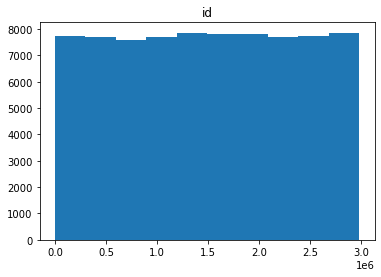

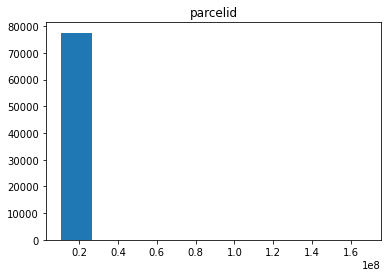

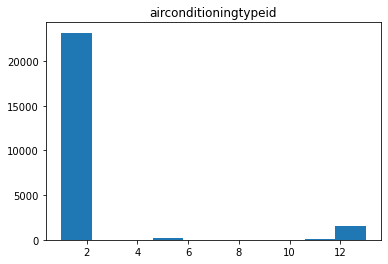

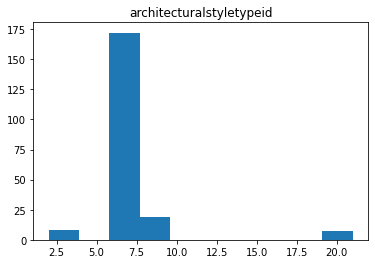

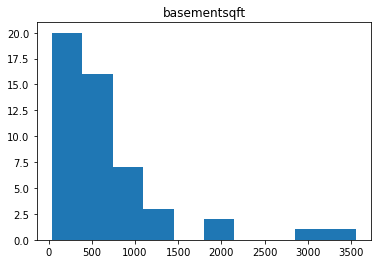

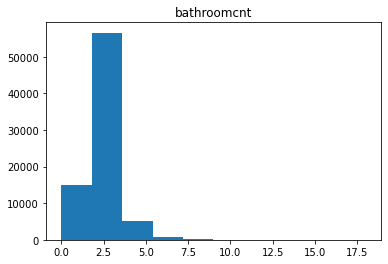

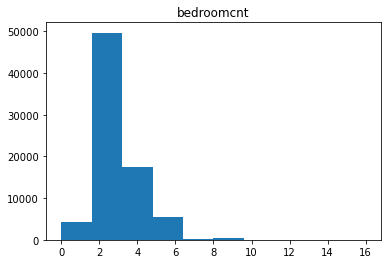

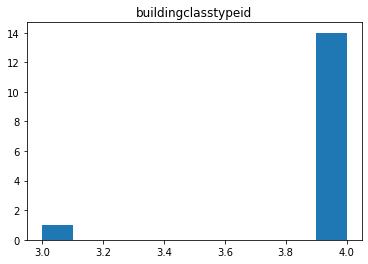

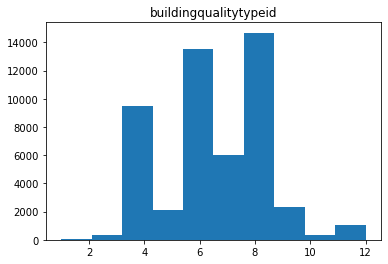

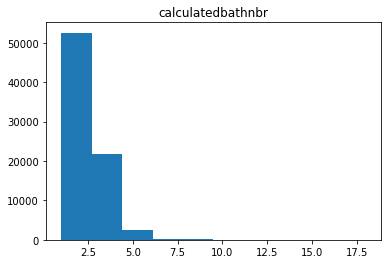

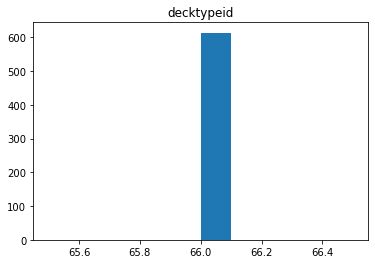

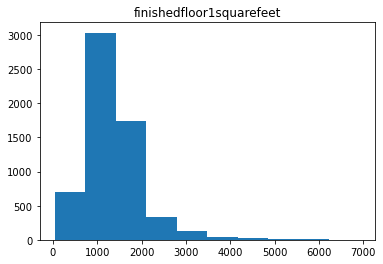

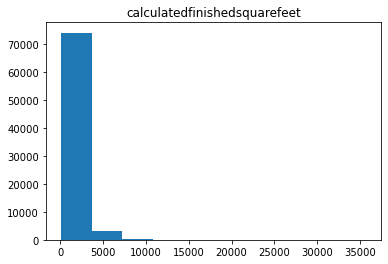

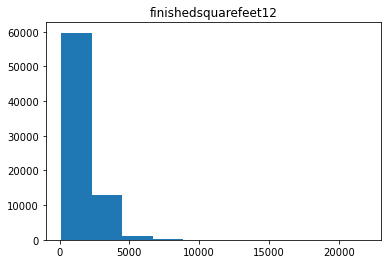

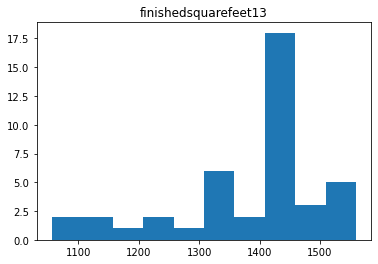

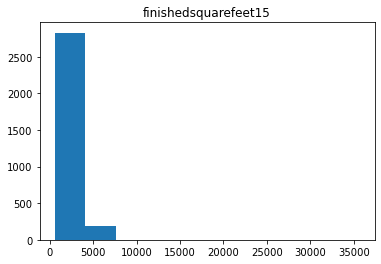

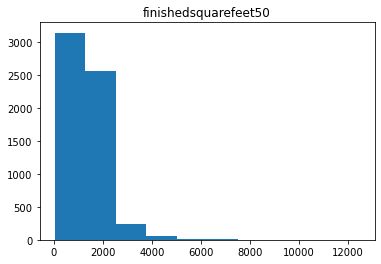

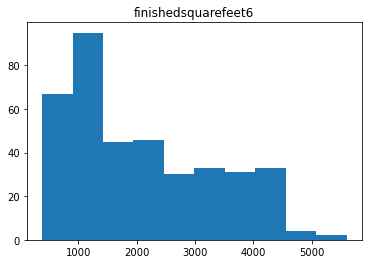

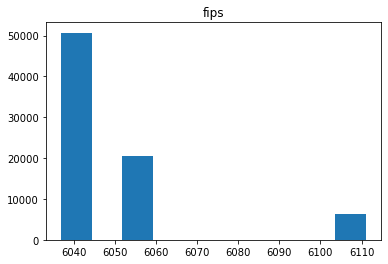

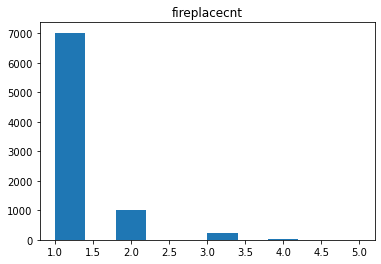

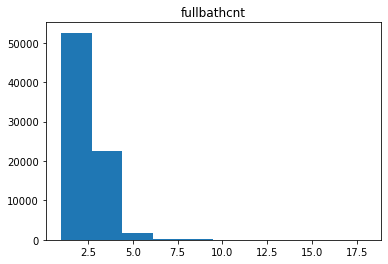

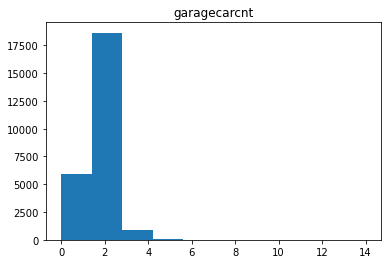

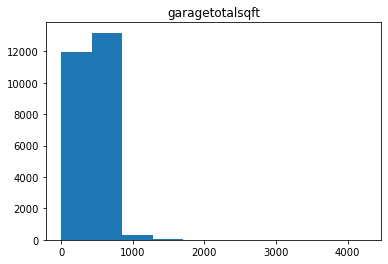

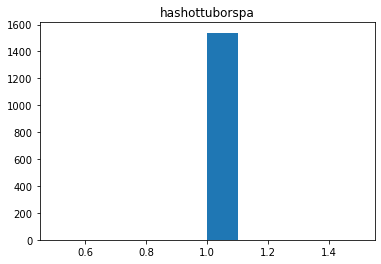

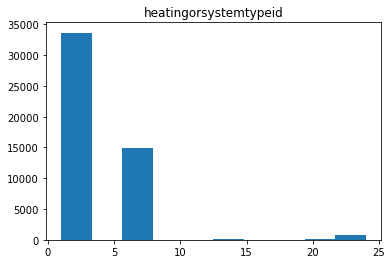

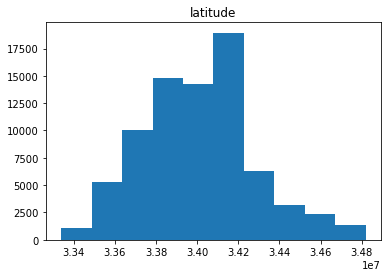

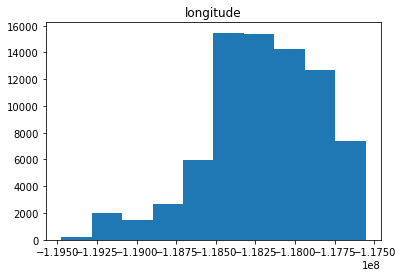

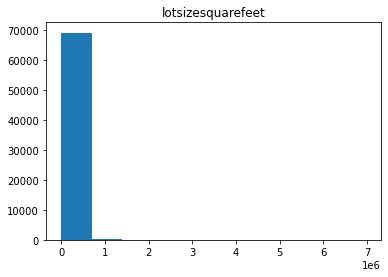

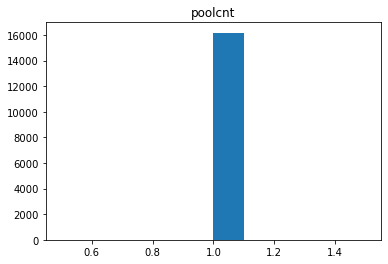

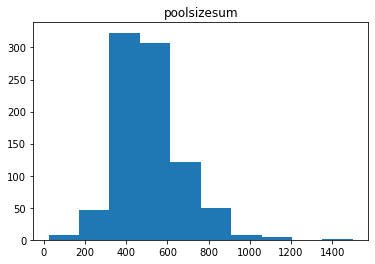

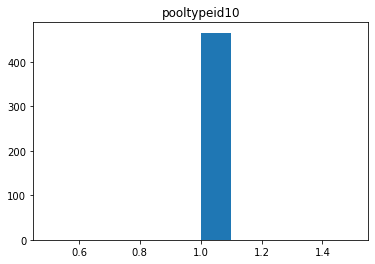

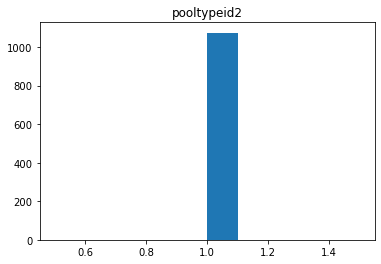

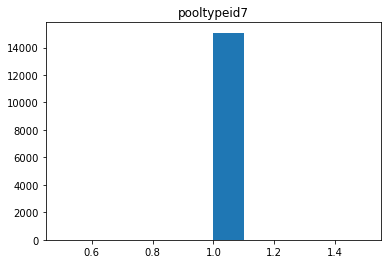

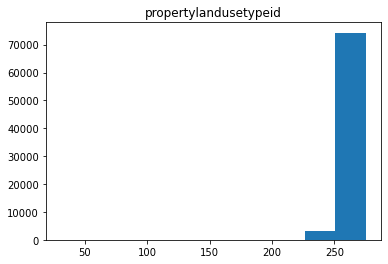

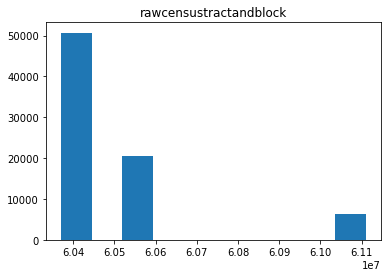

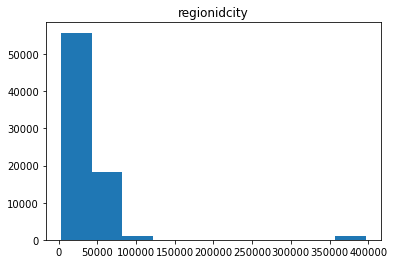

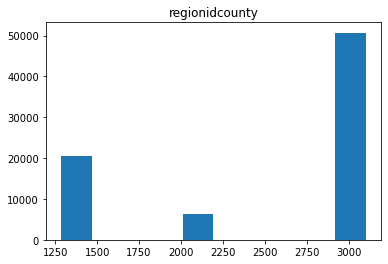

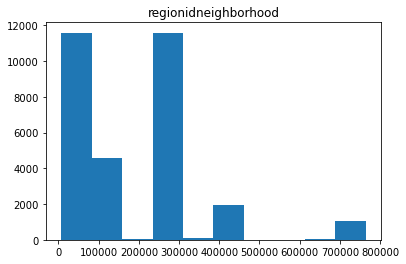

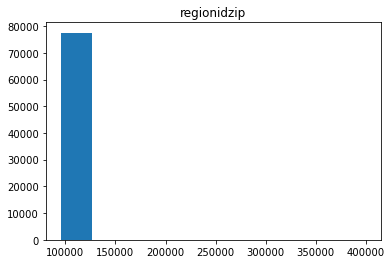

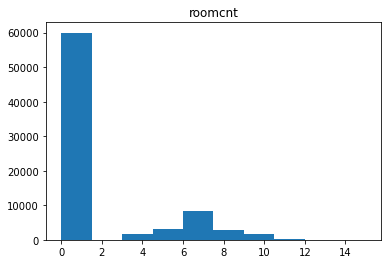

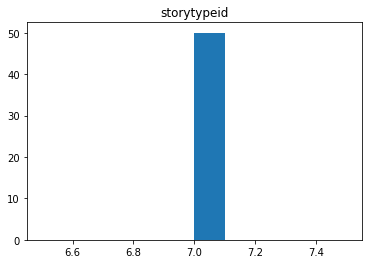

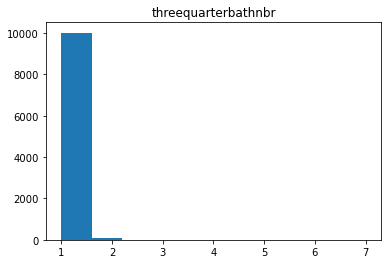

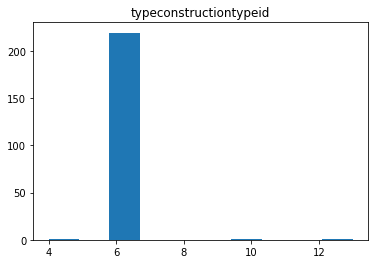

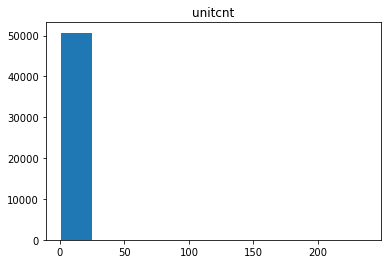

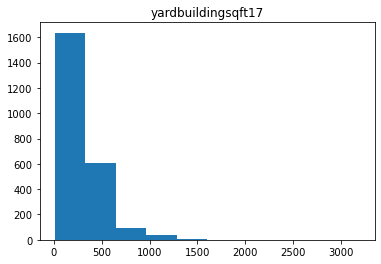

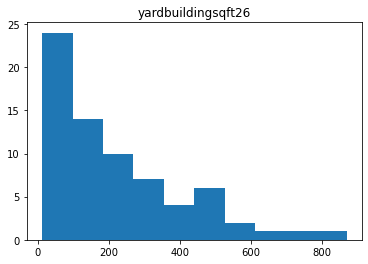

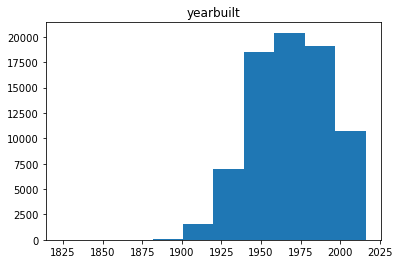

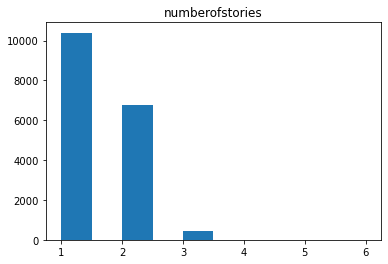

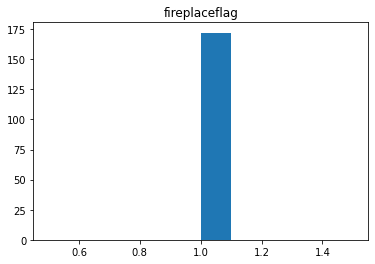

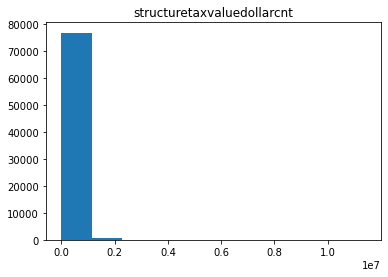

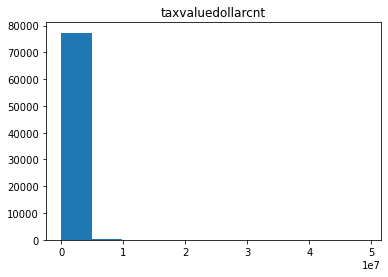

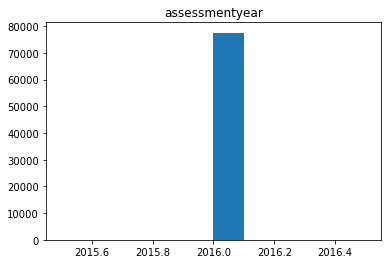

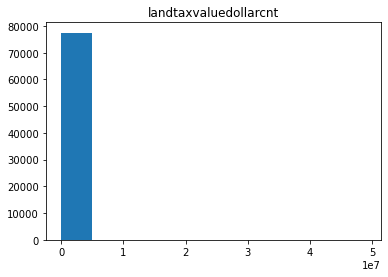

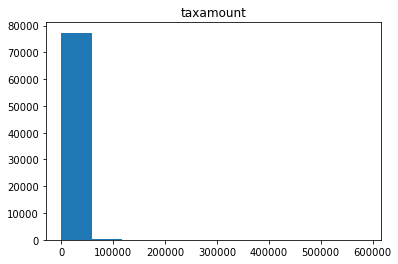

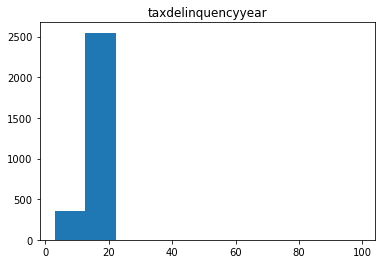

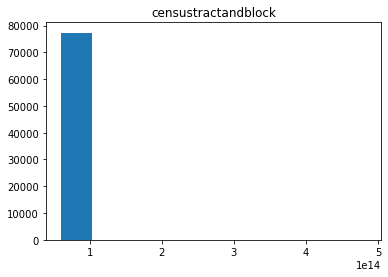

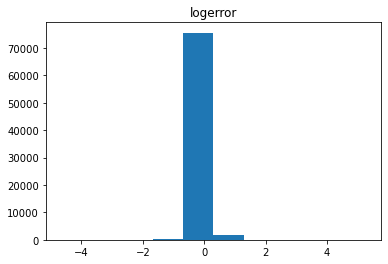

In [13]:
# List of columns
cols = df [df.columns[(df.dtypes != 'O')]]


for col in cols:
   
    # Title with columns name.
    plt.title(col)
    # histogram of each column 
    plt.hist(df[col])
    plt.show()

In [14]:
obj_cols =df [df.columns[(df.dtypes == 'O')]]
obj_cols

,propertycountylandusecode,propertyzoningdesc,taxdelinquencyflag,transactiondate,typeconstructiondesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,propertylandusedesc,storydesc
0,122,NaN,NaN,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
1,1110,NaN,NaN,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
2,122,NaN,NaN,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
3,0101,LCR110000*,NaN,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
4,010C,LAR3,NaN,2017-01-01,NaN,Central,NaN,NaN,Condominium,NaN
...,...,...,...,...,...,...,...,...,...,...
77569,010C,LARD3,NaN,2017-09-20,NaN,Central,NaN,NaN,Condominium,NaN
77570,0100,LARE40,NaN,2017-09-20,NaN,NaN,NaN,NaN,Single Family Residential,NaN
77571,1111,NaN,NaN,2017-09-21,NaN,NaN,NaN,NaN,Single Family Residential,NaN
77572,0100,SER1*,NaN,2017-09-21,NaN,Central,NaN,NaN,Single Family Residential,NaN


In [15]:
for col in obj_cols:
    print(col)
    print(df[col].value_counts())
    print('------------------------')

propertycountylandusecode
0100    26781
122     13067
010C     8838
0101     6413
34       4931
        ...  
0115        1
0131        1
1432        1
040G        1
020E        1
Name: propertycountylandusecode, Length: 75, dtype: int64
------------------------
propertyzoningdesc
LAR1         6766
LAR3         2449
LARS         1394
LBR1N        1225
LARD1.5      1132
             ... 
LCCM*           1
BFA16000*       1
LCPR*           1
LYR2            1
BFA15000*       1
Name: propertyzoningdesc, Length: 1907, dtype: int64
------------------------
taxdelinquencyflag
Y    2900
Name: taxdelinquencyflag, dtype: int64
------------------------
transactiondate
2017-06-30    1194
2017-04-28     917
2017-05-31     868
2017-07-28     815
2017-08-31     782
              ... 
2017-03-12       1
2017-07-22       1
2017-08-05       1
2017-08-06       1
2017-09-25       1
Name: transactiondate, Length: 264, dtype: int64
------------------------
typeconstructiondesc
Frame       219
Masonry      

In [16]:
df.isnull().sum().sort_values(ascending=False)[:45]

buildingclassdesc           77559
buildingclasstypeid         77559
finishedsquarefeet13        77532
storydesc                   77524
storytypeid                 77524
basementsqft                77524
yardbuildingsqft26          77504
fireplaceflag               77402
architecturalstyletypeid    77368
architecturalstyledesc      77368
typeconstructiontypeid      77352
typeconstructiondesc        77352
finishedsquarefeet6         77188
pooltypeid10                77109
decktypeid                  76960
poolsizesum                 76705
pooltypeid2                 76500
hashottuborspa              76035
yardbuildingsqft17          75181
taxdelinquencyyear          74674
taxdelinquencyflag          74674
finishedsquarefeet15        74547
finishedsquarefeet50        71539
finishedfloor1squarefeet    71539
fireplacecnt                69287
threequarterbathnbr         67469
pooltypeid7                 62496
poolcnt                     61401
numberofstories             59978
airconditionin

### Takeaways:
- lots of null values
- multiple columns with very liitle input
- outliers are skewing charts

# Prepare

### Look up null values

In [17]:
# get the numbers of rows missinig per column
num_rows_missing = df.isnull().sum()
# 3500 is a little more than 50% 
[num_rows_missing[(num_rows_missing > 40000) == True]]

[airconditioningtypeid       52568
 architecturalstyletypeid    77368
 basementsqft                77524
 buildingclasstypeid         77559
 decktypeid                  76960
 finishedfloor1squarefeet    71539
 finishedsquarefeet13        77532
 finishedsquarefeet15        74547
 finishedsquarefeet50        71539
 finishedsquarefeet6         77188
 fireplacecnt                69287
 garagecarcnt                52057
 garagetotalsqft             52057
 hashottuborspa              76035
 poolcnt                     61401
 poolsizesum                 76705
 pooltypeid10                77109
 pooltypeid2                 76500
 pooltypeid7                 62496
 regionidneighborhood        46601
 storytypeid                 77524
 threequarterbathnbr         67469
 typeconstructiontypeid      77352
 yardbuildingsqft17          75181
 yardbuildingsqft26          77504
 numberofstories             59978
 fireplaceflag               77402
 taxdelinquencyflag          74674
 taxdelinquencyyear 

In [18]:
# get the number of rows to calculate percentage
num_rows = df.shape[0]
num_rows

77574

In [19]:
# Calculate percent of missing
pct_rows_missing = num_rows_missing/num_rows
# display number of rows with more than 70% missing
pct_rows_missing[pct_rows_missing >.7]

architecturalstyletypeid    0.997344
basementsqft                0.999355
buildingclasstypeid         0.999807
decktypeid                  0.992085
finishedfloor1squarefeet    0.922203
finishedsquarefeet13        0.999459
finishedsquarefeet15        0.960979
finishedsquarefeet50        0.922203
finishedsquarefeet6         0.995024
fireplacecnt                0.893173
hashottuborspa              0.980161
poolcnt                     0.791515
poolsizesum                 0.988798
pooltypeid10                0.994006
pooltypeid2                 0.986155
pooltypeid7                 0.805631
storytypeid                 0.999355
threequarterbathnbr         0.869737
typeconstructiontypeid      0.997138
yardbuildingsqft17          0.969152
yardbuildingsqft26          0.999098
numberofstories             0.773171
fireplaceflag               0.997783
taxdelinquencyflag          0.962616
taxdelinquencyyear          0.962616
typeconstructiondesc        0.997138
architecturalstyledesc      0.997344
b

In [20]:
# Make dataframe
pd.DataFrame({'number_missing_rows': num_rows_missing, 'percent_rows_missing': pct_rows_missing})

,number_missing_rows,percent_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,52568,0.677650
architecturalstyletypeid,77368,0.997344
basementsqft,77524,0.999355
...,...,...
airconditioningdesc,52568,0.677650
architecturalstyledesc,77368,0.997344
buildingclassdesc,77559,0.999807
propertylandusedesc,0,0.000000


### Create a function to get nulls by column for future use

In [21]:
def nulls_by_col(df):
    num_rows_missing = df.isnull().sum()
    pct_rows_missing = num_rows_missing/num_rows
    df_missing = pd.DataFrame({'number_missing_rows': num_rows_missing, 'percent_rows_missing': pct_rows_missing})
    return df_missing
    

In [22]:
# test the function
nulls_by_col(df)

,number_missing_rows,percent_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,52568,0.677650
architecturalstyletypeid,77368,0.997344
basementsqft,77524,0.999355
...,...,...
airconditioningdesc,52568,0.677650
architecturalstyledesc,77368,0.997344
buildingclassdesc,77559,0.999807
propertylandusedesc,0,0.000000


### Look up nulls by rows 

In [23]:
# get the numner of rows missing values and sort by number nulls
df.isna().sum(axis = 1).value_counts()

34    14891
33    14062
32    13790
31    11549
35     6299
29     5328
30     3963
36     3560
37     2084
28      619
27      498
38      296
39      230
26      129
43       79
44       50
25       34
42       29
40       29
41       26
24       14
45        5
23        4
47        3
46        3
dtype: int64

In [24]:
# Create a dataframe to hold the number of columns missing and the number of rows missing
col_missing = pd.DataFrame(df.isna().sum(axis =1), columns = ['num_cols_missing']).reset_index().groupby('num_cols_missing')
col_missing = col_missing.count().reset_index().rename(columns = {'index': 'num_rows'})
col_missing

,num_cols_missing,num_rows
0,23,4
1,24,14
2,25,34
3,26,129
4,27,498
5,28,619
6,29,5328
7,30,3963
8,31,11549
9,32,13790


In [25]:
# add a column calculating the percentage 
col_missing['pct_cols_missing'] = col_missing.num_cols_missing/df.shape[1]
col_missing

,num_cols_missing,num_rows,pct_cols_missing
0,23,4,0.343284
1,24,14,0.358209
2,25,34,0.373134
3,26,129,0.388060
4,27,498,0.402985
5,28,619,0.417910
6,29,5328,0.432836
7,30,3963,0.447761
8,31,11549,0.462687
9,32,13790,0.477612


### Create a function for future use

In [26]:
def nulls_by_row(df):
    miss_df = pd.DataFrame(df.isna().sum(axis =1), columns = ['num_cols_missing']).reset_index().groupby('num_cols_missing')
    miss_df = miss_df.count().reset_index().rename(columns = {'index': 'num_rows' })
   
    miss_df['pct_cols_missing'] = miss_df.num_cols_missing/df.shape[1]
   
    return miss_df

In [27]:
# Test the function
nulls_by_row(df)

,num_cols_missing,num_rows,pct_cols_missing
0,23,4,0.343284
1,24,14,0.358209
2,25,34,0.373134
3,26,129,0.388060
4,27,498,0.402985
5,28,619,0.417910
6,29,5328,0.432836
7,30,3963,0.447761
8,31,11549,0.462687
9,32,13790,0.477612


### Drop columns that have greater than 50% nulls

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77574 entries, 0 to 77573
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

### Create a function that will drop rows or columns based on the percent of values that are missing. 

This will allow us to drop columns with the percentage we want, let's try rows and columns that are missing 50%.

In [29]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .5):
    '''
    function that will drop rows or columns based on the 
    percent of values that are missing
    '''
    n_required_column = round(df.shape[0] * prop_required_column)
    n_required_row = round(df.shape[1] * prop_required_row)
    df = df.dropna(axis=0, thresh=n_required_row)
    df = df.dropna(axis=1, thresh=n_required_column)
    return df   

In [30]:
# Assign it a different variable to compare
df1 = handle_missing_values(df)
df1.shape, df.shape

((49990, 29), (77574, 67))

#### Compare info, describe, nulls by row, and nulls by column

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49990 entries, 1 to 77572
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            49990 non-null  int64  
 1   parcelid                      49990 non-null  int64  
 2   bathroomcnt                   49990 non-null  float64
 3   bedroomcnt                    49990 non-null  float64
 4   calculatedbathnbr             49973 non-null  float64
 5   calculatedfinishedsquarefeet  49989 non-null  float64
 6   finishedsquarefeet12          49214 non-null  float64
 7   fips                          49990 non-null  float64
 8   fullbathcnt                   49973 non-null  float64
 9   latitude                      49990 non-null  float64
 10  longitude                     49990 non-null  float64
 11  lotsizesquarefeet             47627 non-null  float64
 12  propertycountylandusecode     49990 non-null  object 
 13  p

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77574 entries, 0 to 77573
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

In [33]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,49990.0,1.492904e+06,8.631140e+05,3.490000e+02,7.464530e+05,1.494348e+06,2.241454e+06,2.982188e+06
parcelid,49990.0,1.271534e+07,2.357313e+06,1.071186e+07,1.121270e+07,1.207151e+07,1.309760e+07,1.629608e+08
bathroomcnt,49990.0,2.407171e+00,1.002577e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,49990.0,3.098720e+00,1.079561e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
calculatedbathnbr,49973.0,2.407990e+00,1.001764e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
calculatedfinishedsquarefeet,49989.0,1.866926e+03,1.013322e+03,1.520000e+02,1.227000e+03,1.606000e+03,2.222000e+03,2.192900e+04
finishedsquarefeet12,49214.0,1.859886e+03,1.011928e+03,1.520000e+02,1.223000e+03,1.600000e+03,2.209000e+03,2.192900e+04
fips,49990.0,6.048552e+03,2.389910e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03,6.111000e+03
fullbathcnt,49973.0,2.355452e+00,9.903592e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
latitude,49990.0,3.409270e+07,2.466035e+05,3.333953e+07,3.392535e+07,3.411622e+07,3.422231e+07,3.481877e+07


In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,77574.0,1.495340e+06,8.609689e+05,3.490000e+02,7.520875e+05,1.498169e+06,2.240588e+06,2.982274e+06
parcelid,77574.0,1.300630e+07,3.478043e+06,1.071186e+07,1.153819e+07,1.253050e+07,1.421124e+07,1.676893e+08
airconditioningtypeid,25006.0,1.812045e+00,2.965823e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77574.0,2.298521e+00,9.967057e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77574.0,3.053252e+00,1.140447e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49808.0,6.533830e+00,1.722041e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76959.0,2.316389e+00,9.796902e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01


In [35]:
nulls_by_col(df1)

,number_missing_rows,percent_rows_missing
id,0,0.000000
parcelid,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
calculatedbathnbr,17,0.000219
calculatedfinishedsquarefeet,1,0.000013
finishedsquarefeet12,776,0.010003
fips,0,0.000000
fullbathcnt,17,0.000219
latitude,0,0.000000


In [36]:
nulls_by_col(df)

,number_missing_rows,percent_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,52568,0.677650
architecturalstyletypeid,77368,0.997344
basementsqft,77524,0.999355
...,...,...
airconditioningdesc,52568,0.677650
architecturalstyledesc,77368,0.997344
buildingclassdesc,77559,0.999807
propertylandusedesc,0,0.000000


In [37]:
nulls_by_row(df1)

,num_cols_missing,num_rows,pct_cols_missing
0,0,45983,0.000000
1,1,3926,0.034483
2,2,70,0.068966
3,3,8,0.103448
4,4,3,0.137931


In [38]:
nulls_by_row(df)

,num_cols_missing,num_rows,pct_cols_missing
0,23,4,0.343284
1,24,14,0.358209
2,25,34,0.373134
3,26,129,0.388060
4,27,498,0.402985
5,28,619,0.417910
6,29,5328,0.432836
7,30,3963,0.447761
8,31,11549,0.462687
9,32,13790,0.477612


#### Takeaways:

- From 77,574 to 49,990 rows
- From 67 to 29 columns
- The highest percent of rows nulls went from 70% to 14%
- The highest percent of columns nulls went from 99% to 3%

Overall a good move we have better and more accurate data

#### Recheck information after removing nulls

In [39]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,49990.0,1.492904e+06,8.631140e+05,3.490000e+02,7.464530e+05,1.494348e+06,2.241454e+06,2.982188e+06
parcelid,49990.0,1.271534e+07,2.357313e+06,1.071186e+07,1.121270e+07,1.207151e+07,1.309760e+07,1.629608e+08
bathroomcnt,49990.0,2.407171e+00,1.002577e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,49990.0,3.098720e+00,1.079561e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
calculatedbathnbr,49973.0,2.407990e+00,1.001764e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
calculatedfinishedsquarefeet,49989.0,1.866926e+03,1.013322e+03,1.520000e+02,1.227000e+03,1.606000e+03,2.222000e+03,2.192900e+04
finishedsquarefeet12,49214.0,1.859886e+03,1.011928e+03,1.520000e+02,1.223000e+03,1.600000e+03,2.209000e+03,2.192900e+04
fips,49990.0,6.048552e+03,2.389910e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03,6.111000e+03
fullbathcnt,49973.0,2.355452e+00,9.903592e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
latitude,49990.0,3.409270e+07,2.466035e+05,3.333953e+07,3.392535e+07,3.411622e+07,3.422231e+07,3.481877e+07


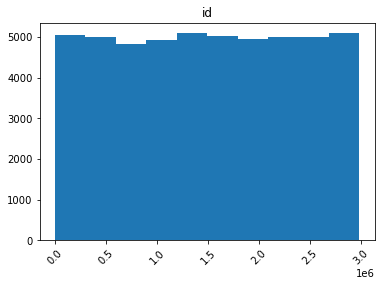

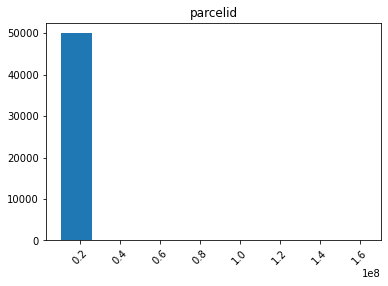

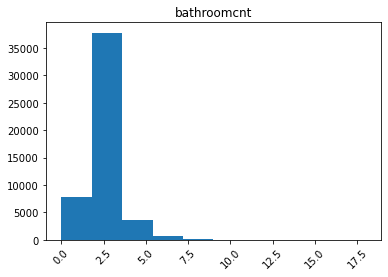

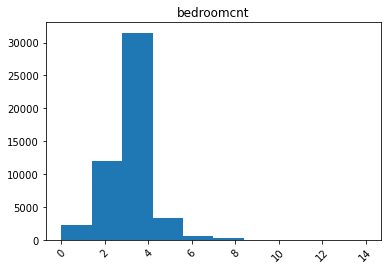

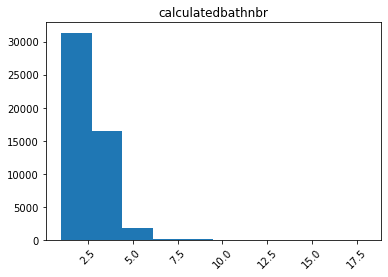

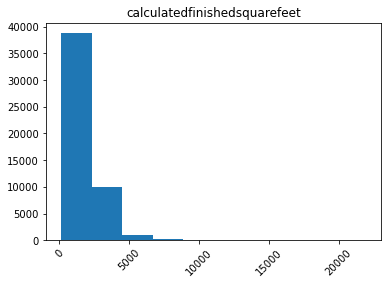

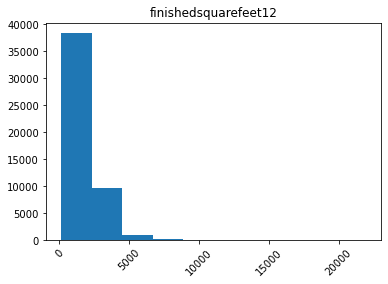

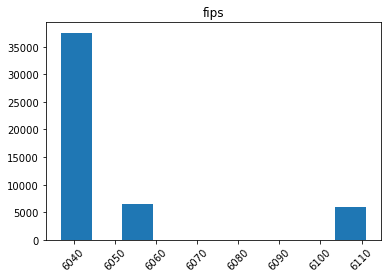

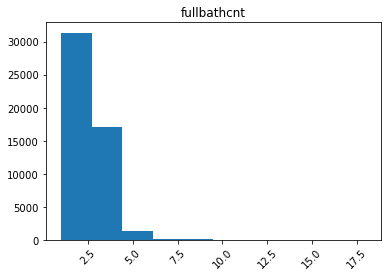

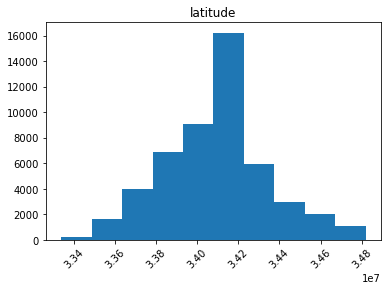

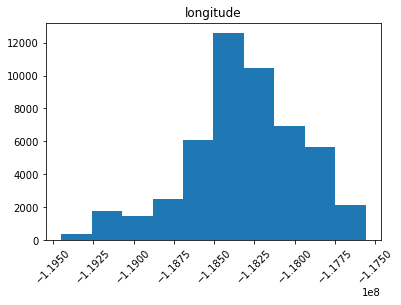

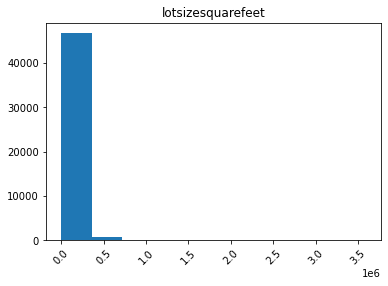

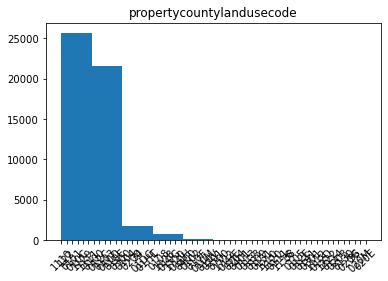

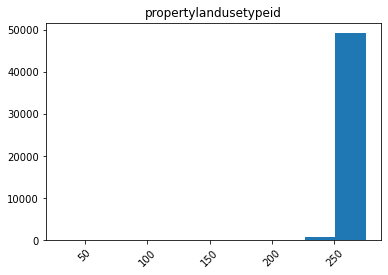

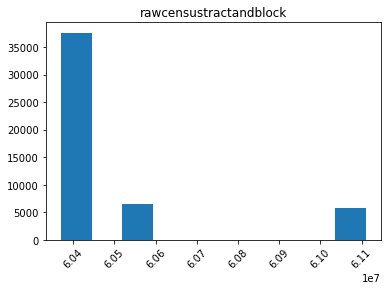

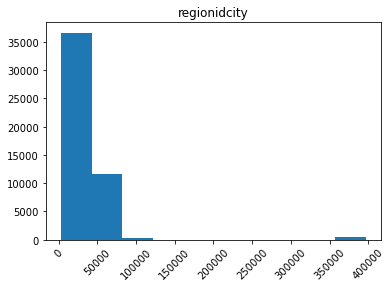

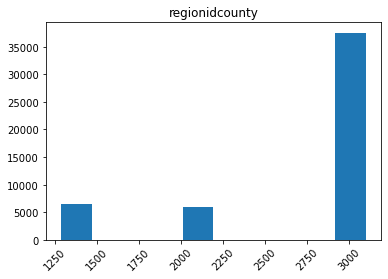

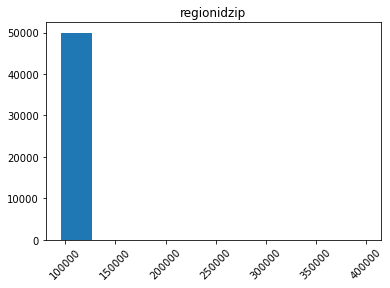

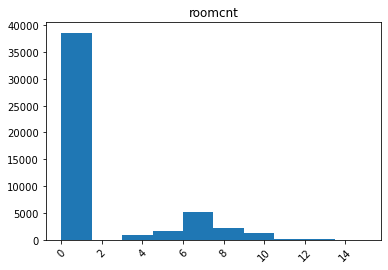

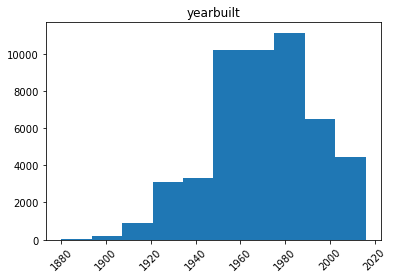

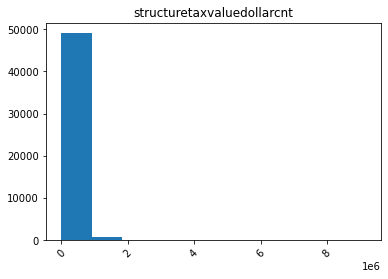

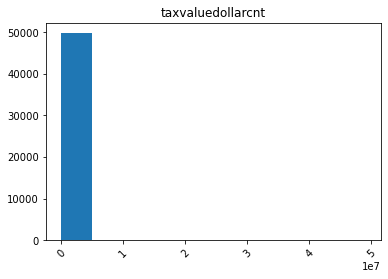

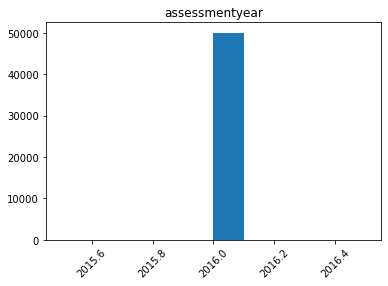

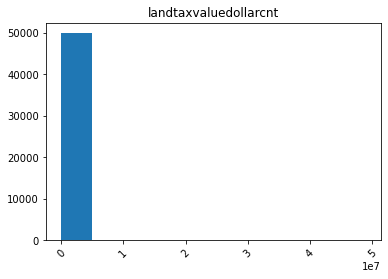

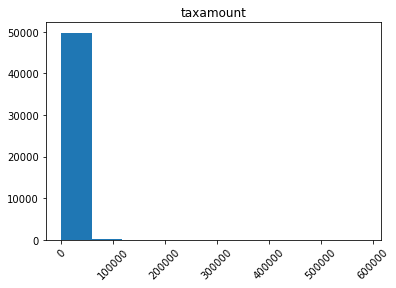

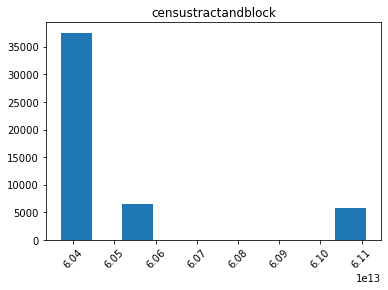

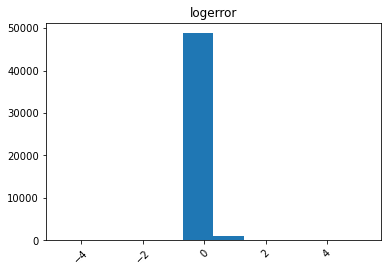

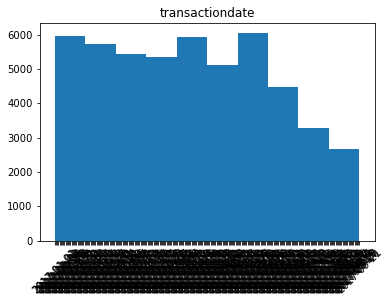

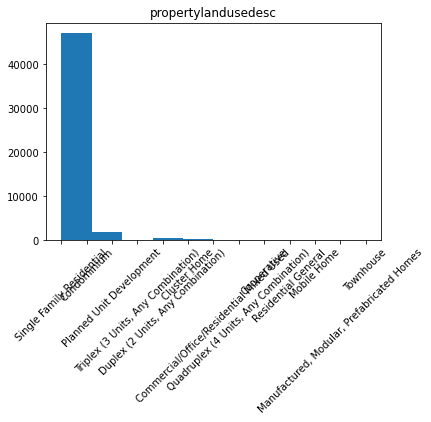

In [40]:
for col in df1.columns:
   
    # Title with columns name.
    plt.title(col)
    # histogram of each column 
    plt.hist(df1[col])
    plt.xticks(rotation=45)
    plt.show()

In [41]:
for col in df1.columns:
    print(col)
    print(df1[col].value_counts())
    print('------------------------')

id
2684934    2
451211     2
1834372    2
2079054    2
711237     2
          ..
2224184    1
2894525    1
297781     1
1718601    1
1843709    1
Name: id, Length: 49873, dtype: int64
------------------------
parcelid
17225336    2
11446756    2
11705026    2
12035592    2
13067643    2
           ..
10914726    1
10833580    1
11483612    1
11206894    1
12773139    1
Name: parcelid, Length: 49873, dtype: int64
------------------------
bathroomcnt
2.0     20407
3.0     13612
1.0      7084
2.5      3146
4.0      2325
5.0       865
1.5       707
3.5       600
4.5       471
6.0       345
5.5       171
7.0        89
8.0        67
6.5        39
9.0        17
0.0        17
7.5        14
10.0        6
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathroomcnt, dtype: int64
------------------------
bedroomcnt
3.0     19340
4.0     12169
2.0     11986
5.0      3349
1.0      2095
6.0       608
0.0       218
7.0       116
8.0        69
9.0        25
10.0       10
11.0        2
12.

#### Takeaways:

- There are columns that have duplicated information:
    - square footage
    - propertylanduse
    - bathroom and bedroom counts
- Id is useless for our purposes so we can drop it
- Census information does not seem to be important for our intent. We can drop it
- assessment year it is all done at the same time.It can be dropped as well
- Address Outliers:
    - bedroom min is 0
    - bedroom max is 14
    - bathroom min is 0
    - batroom max is 18
    - calculatedfinishedsquarefeet	min is 152 sq. ft.	
    - calculatedfinishedsquarefeet max is 21,929 sq. ft.


### Remove columns

In [42]:
# drop columns not needed
cols_to_remove = ['id', 'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'roomcnt',
'propertycountylandusecode', 'propertylandusetypeid', 'censustractandblock', 'rawcensustractandblock', 'assessmentyear']

In [43]:
df1.drop(columns = cols_to_remove)
df1

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
1,1387261,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,11677,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential
3,2288172,12177905,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Single Family Residential
4,1970746,10887214,3.0,3.0,3.0,1312.0,1312.0,6037.0,3.0,34185120.0,...,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,Condominium
5,1447245,17143294,2.0,3.0,2.0,1492.0,1492.0,6111.0,2.0,34230044.0,...,1982.0,198640.0,331064.0,2016.0,132424.0,3508.10,6.111005e+13,-0.020526,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77567,1373391,10722691,2.0,3.0,2.0,1570.0,1570.0,6037.0,2.0,34194943.0,...,1958.0,46784.0,72026.0,2016.0,25242.0,1000.70,6.037135e+13,0.081196,2017-09-19,Single Family Residential
77569,2864704,10833991,3.0,3.0,3.0,1741.0,1741.0,6037.0,3.0,34202400.0,...,1980.0,265000.0,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,Condominium
77570,673515,11000655,2.0,2.0,2.0,1286.0,1286.0,6037.0,2.0,34245368.0,...,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Single Family Residential
77571,2968375,17239384,2.0,4.0,2.0,1612.0,1612.0,6111.0,2.0,34300140.0,...,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,Single Family Residential


In [44]:
df1

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
1,1387261,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,11677,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential
3,2288172,12177905,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Single Family Residential
4,1970746,10887214,3.0,3.0,3.0,1312.0,1312.0,6037.0,3.0,34185120.0,...,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,Condominium
5,1447245,17143294,2.0,3.0,2.0,1492.0,1492.0,6111.0,2.0,34230044.0,...,1982.0,198640.0,331064.0,2016.0,132424.0,3508.10,6.111005e+13,-0.020526,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77567,1373391,10722691,2.0,3.0,2.0,1570.0,1570.0,6037.0,2.0,34194943.0,...,1958.0,46784.0,72026.0,2016.0,25242.0,1000.70,6.037135e+13,0.081196,2017-09-19,Single Family Residential
77569,2864704,10833991,3.0,3.0,3.0,1741.0,1741.0,6037.0,3.0,34202400.0,...,1980.0,265000.0,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,Condominium
77570,673515,11000655,2.0,2.0,2.0,1286.0,1286.0,6037.0,2.0,34245368.0,...,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Single Family Residential
77571,2968375,17239384,2.0,4.0,2.0,1612.0,1612.0,6111.0,2.0,34300140.0,...,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,Single Family Residential


#### Create a function to remove columns

In [45]:
def remove_columns(df, cols_to_remove):  
    df = df.drop(columns = cols_to_remove)
    return df

In [46]:
df1 = remove_columns(df1, cols_to_remove)

#### Remove outliers

In [47]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,49990.0,1.271534e+07,2.357313e+06,1.071186e+07,1.121270e+07,1.207151e+07,1.309760e+07,1.629608e+08
bathroomcnt,49990.0,2.407171e+00,1.002577e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,49990.0,3.098720e+00,1.079561e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
calculatedfinishedsquarefeet,49989.0,1.866926e+03,1.013322e+03,1.520000e+02,1.227000e+03,1.606000e+03,2.222000e+03,2.192900e+04
fips,49990.0,6.048552e+03,2.389910e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03,6.111000e+03
latitude,49990.0,3.409270e+07,2.466035e+05,3.333953e+07,3.392535e+07,3.411622e+07,3.422231e+07,3.481877e+07
longitude,49990.0,-1.183133e+08,3.543797e+05,-1.194484e+08,-1.184974e+08,-1.183128e+08,-1.180843e+08,-1.175600e+08
lotsizesquarefeet,47627.0,3.632871e+04,1.101027e+05,2.360000e+02,6.045000e+03,7.805000e+03,1.740050e+04,3.589145e+06
regionidcity,49171.0,3.064925e+04,4.165095e+04,3.491000e+03,1.244700e+04,2.000800e+04,4.483300e+04,3.965560e+05
regionidcounty,49990.0,2.740897e+03,6.554147e+02,1.286000e+03,3.101000e+03,3.101000e+03,3.101000e+03,3.101000e+03


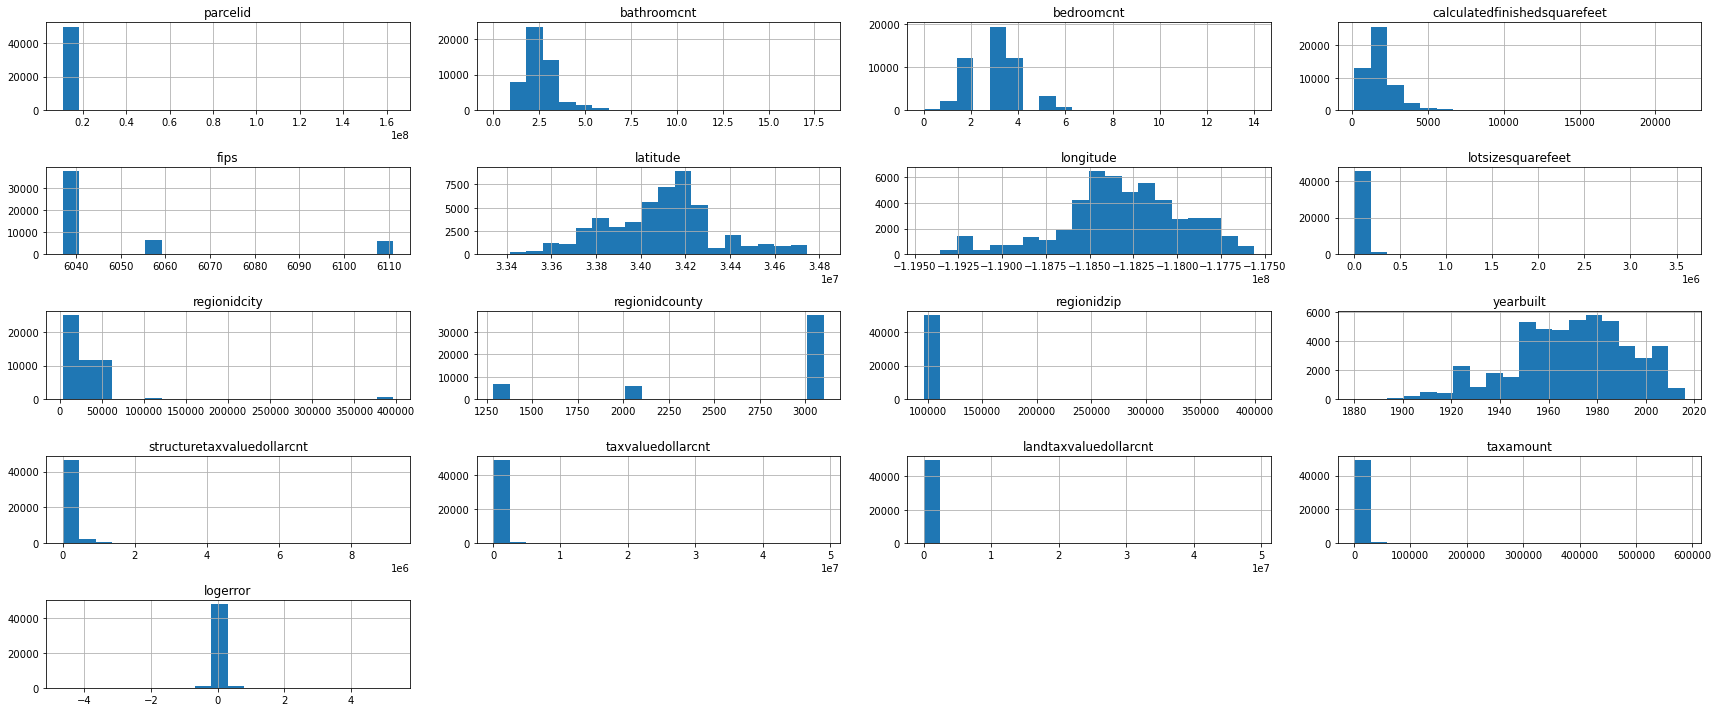

In [48]:
df1.hist(figsize=(24, 10), bins=20)
plt.tight_layout()

In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49990 entries, 1 to 77572
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      49990 non-null  int64  
 1   bathroomcnt                   49990 non-null  float64
 2   bedroomcnt                    49990 non-null  float64
 3   calculatedfinishedsquarefeet  49989 non-null  float64
 4   fips                          49990 non-null  float64
 5   latitude                      49990 non-null  float64
 6   longitude                     49990 non-null  float64
 7   lotsizesquarefeet             47627 non-null  float64
 8   regionidcity                  49171 non-null  float64
 9   regionidcounty                49990 non-null  float64
 10  regionidzip                   49988 non-null  float64
 11  yearbuilt                     49968 non-null  float64
 12  structuretaxvaluedollarcnt    49968 non-null  float64
 13  t

### Remove outliers, I will be removing only extreme outliers, since our goal is to find a driver of error

- bathroomcnt greater 1 and less than 7 will be an acceptable range
- bedroomcnt greater 1 and less than 7 will be an acceptable range
- calculatedfinishedsquarefeet 6,000 sq ft is too much to be a home but most properties will be undet that value  also anything under 350 sq ft is too small to be a home
- lotsizesquarefeet most data is less than 500,000
- regionidzip there is an error and added an extra digit all zipcodes are five digits so less than 100,000 is the best option
- structuretaxvaluedollarcnt majority of data is under 2 million
- taxvaluedollarcnt majority of data is under 2 million
- landtaxvaluedollarcnt majority of data is under 1.5 million
- taxamount majority of data is under 30 thousand

In [50]:
# add the values as conditions for the dataframe so that the outliers can be removed
df1[((df1.bathroomcnt <= 7) & (df1.bedroomcnt <= 7) &  
               (df1.bathroomcnt > 0) & 
               (df1.bedroomcnt > 0) & 
               (df1.calculatedfinishedsquarefeet > 350) & 
               (df1.calculatedfinishedsquarefeet < 6000) & 
               (df1.lotsizesquarefeet < 500_000) &
               (df1.regionidzip < 100_000) &
               (df1.structuretaxvaluedollarcnt < 1_000_000) &
               (df1.taxvaluedollarcnt < 2_000_000) &
               (df1.landtaxvaluedollarcnt < 1_500_000) &
               (df1.taxamount < 30_000)
              )]

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc
1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,2061.0,97099.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01,Single Family Residential
2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,21412.0,1286.0,97078.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01,Single Family Residential
3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,396551.0,3101.0,96330.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01,Single Family Residential
4,10887214,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,12447.0,3101.0,96451.0,1964.0,73681.0,119407.0,45726.0,1533.89,0.006940,2017-01-01,Condominium
5,17143294,2.0,3.0,1492.0,6111.0,34230044.0,-118993991.0,903.0,51239.0,2061.0,97091.0,1982.0,198640.0,331064.0,132424.0,3508.10,-0.020526,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77567,10722691,2.0,3.0,1570.0,6037.0,34194943.0,-118629218.0,7499.0,12447.0,3101.0,96342.0,1958.0,46784.0,72026.0,25242.0,1000.70,0.081196,2017-09-19,Single Family Residential
77569,10833991,3.0,3.0,1741.0,6037.0,34202400.0,-118502000.0,59487.0,12447.0,3101.0,96415.0,1980.0,265000.0,379000.0,114000.0,4685.34,-0.002245,2017-09-20,Condominium
77570,11000655,2.0,2.0,1286.0,6037.0,34245368.0,-118282383.0,47405.0,12447.0,3101.0,96284.0,1940.0,70917.0,354621.0,283704.0,4478.43,0.020615,2017-09-20,Single Family Residential
77571,17239384,2.0,4.0,1612.0,6111.0,34300140.0,-118706327.0,12105.0,27110.0,2061.0,97116.0,1964.0,50683.0,67205.0,16522.0,1107.48,0.013209,2017-09-21,Single Family Residential


#### Make a function to remove outliers

In [51]:
def remove_outliers(df):
    '''
    remove outliers in bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, lotsizesquarefeet,
    structuretaxvaluedollarcnt, taxvaluedollarcnt, landtaxvaluedollarcnt, taxamount
    '''

    return df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) &  
               (df.bathroomcnt > 0) & 
               (df.bedroomcnt > 0) & 
               (df.calculatedfinishedsquarefeet > 350) & 
               (df.calculatedfinishedsquarefeet < 6000) & 
               (df.lotsizesquarefeet < 500_000) &
               (df.regionidzip < 100_000) &
               (df.structuretaxvaluedollarcnt < 1_000_000) &
               (df.taxvaluedollarcnt < 2_000_000) &
               (df.landtaxvaluedollarcnt < 1_500_000) &
               (df.taxamount < 30_000)
              )]

In [52]:
df1 = remove_outliers(df1)

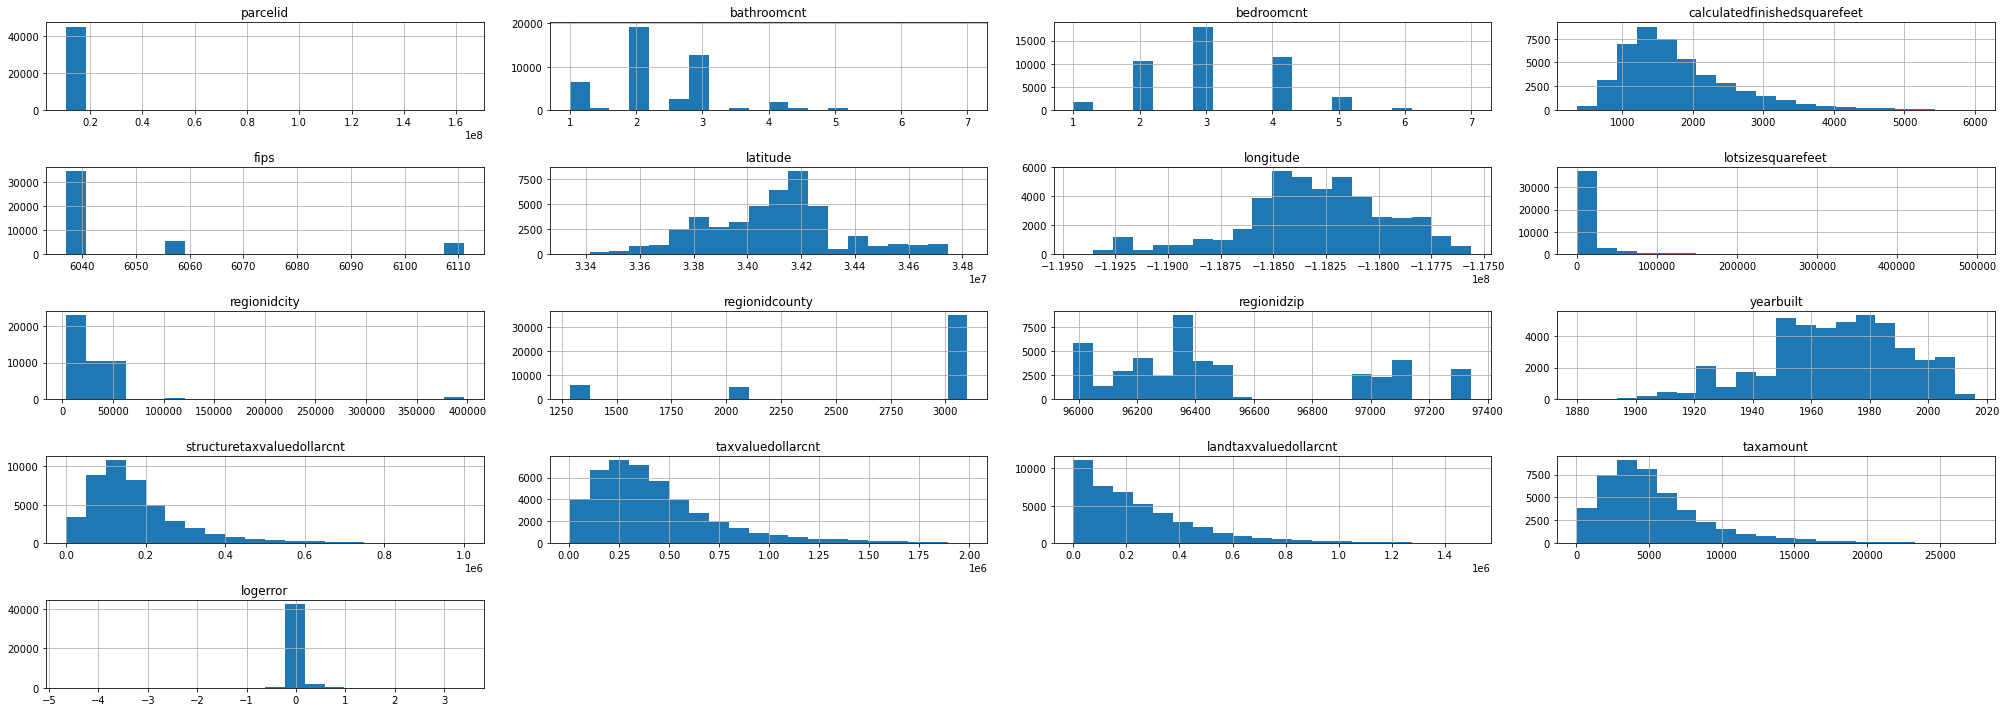

In [53]:
df1.hist(figsize=(28, 10), bins=20)
plt.tight_layout()

#### Add counties names based on fips columns.

In [54]:
df1['county'] = np.where(df1.fips == 6037, 'Los_Angeles', np.where(df1.fips == 6059, 'Orange', 'Ventura'))    

In [55]:
df1.lotsizesquarefeet.median()

7648.0

#### Create a function to clean data

In [64]:

def wrangle_zillow(df):

    # Handle missing values i.e. drop columns and rows based on a threshold
    df = handle_missing_values(df)
        
    # drop columns not needed
    cols_to_remove = ['id', 'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'roomcnt','propertycountylandusecode', 
    'propertylandusetypeid', 'censustractandblock', 'rawcensustractandblock', 'assessmentyear']
    
    df = remove_columns(df, cols_to_remove)
    
    # Columns to look for outliers
    df = remove_outliers(df)
    
    # Add column for counties
    df['county'] = np.where(df.fips == 6037, 'Los_Angeles', np.where(df.fips == 6059, 'Orange', 'Ventura'))    

    # replace nulls with median values for select columns
    lot_median = df.lotsizesquarefeet.median()
    df.lotsizesquarefeet.fillna(lot_median, inplace = True)

    # Just to be sure we caught all nulls, drop them here
    df = df.dropna()
    return df

In [58]:
df2 = get_zillow_data()

Reading from csv file...


In [65]:
df2 = wrangle_zillow(df2)

In [67]:
df2

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc,county
1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,2061.0,97099.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01,Single Family Residential,Ventura
2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,21412.0,1286.0,97078.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01,Single Family Residential,Orange
3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,396551.0,3101.0,96330.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01,Single Family Residential,Los_Angeles
4,10887214,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,12447.0,3101.0,96451.0,1964.0,73681.0,119407.0,45726.0,1533.89,0.006940,2017-01-01,Condominium,Los_Angeles
5,17143294,2.0,3.0,1492.0,6111.0,34230044.0,-118993991.0,903.0,51239.0,2061.0,97091.0,1982.0,198640.0,331064.0,132424.0,3508.10,-0.020526,2017-01-01,Condominium,Ventura
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77567,10722691,2.0,3.0,1570.0,6037.0,34194943.0,-118629218.0,7499.0,12447.0,3101.0,96342.0,1958.0,46784.0,72026.0,25242.0,1000.70,0.081196,2017-09-19,Single Family Residential,Los_Angeles
77569,10833991,3.0,3.0,1741.0,6037.0,34202400.0,-118502000.0,59487.0,12447.0,3101.0,96415.0,1980.0,265000.0,379000.0,114000.0,4685.34,-0.002245,2017-09-20,Condominium,Los_Angeles
77570,11000655,2.0,2.0,1286.0,6037.0,34245368.0,-118282383.0,47405.0,12447.0,3101.0,96284.0,1940.0,70917.0,354621.0,283704.0,4478.43,0.020615,2017-09-20,Single Family Residential,Los_Angeles
77571,17239384,2.0,4.0,1612.0,6111.0,34300140.0,-118706327.0,12105.0,27110.0,2061.0,97116.0,1964.0,50683.0,67205.0,16522.0,1107.48,0.013209,2017-09-21,Single Family Residential,Ventura


In [70]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,44559.0,1.267045e+07,2.373580e+06,1.071186e+07,1.120511e+07,1.207630e+07,1.306360e+07,1.629608e+08
bathroomcnt,44559.0,2.328048e+00,8.734762e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,7.000000e+00
bedroomcnt,44559.0,3.095245e+00,1.001254e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,7.000000e+00
calculatedfinishedsquarefeet,44559.0,1.791689e+03,8.074720e+02,3.600000e+02,1.227000e+03,1.593000e+03,2.165000e+03,5.999000e+03
fips,44559.0,6.047978e+03,2.339200e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03,6.111000e+03
latitude,44559.0,3.409476e+07,2.459700e+05,3.333953e+07,3.392615e+07,3.411780e+07,3.422140e+07,3.481877e+07
longitude,44559.0,-1.183053e+08,3.498343e+05,-1.194484e+08,-1.184849e+08,-1.183014e+08,-1.180809e+08,-1.175723e+08
lotsizesquarefeet,44559.0,2.734253e+04,6.035640e+04,2.360000e+02,6.000000e+03,7.613000e+03,1.506350e+04,4.974960e+05
regionidcity,44559.0,3.066394e+04,4.245968e+04,3.491000e+03,1.244700e+04,2.000800e+04,4.411600e+04,3.965560e+05
regionidcounty,44559.0,2.756290e+03,6.461940e+02,1.286000e+03,3.101000e+03,3.101000e+03,3.101000e+03,3.101000e+03


In [71]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44559 entries, 1 to 77572
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      44559 non-null  int64  
 1   bathroomcnt                   44559 non-null  float64
 2   bedroomcnt                    44559 non-null  float64
 3   calculatedfinishedsquarefeet  44559 non-null  float64
 4   fips                          44559 non-null  float64
 5   latitude                      44559 non-null  float64
 6   longitude                     44559 non-null  float64
 7   lotsizesquarefeet             44559 non-null  float64
 8   regionidcity                  44559 non-null  float64
 9   regionidcounty                44559 non-null  float64
 10  regionidzip                   44559 non-null  float64
 11  yearbuilt                     44559 non-null  float64
 12  structuretaxvaluedollarcnt    44559 non-null  float64
 13  t

## Split the data

In [73]:
# split the data
train_validate, test = train_test_split(df2, test_size=.2, random_state=177)
train, validate = train_test_split(train_validate, test_size=.3, random_state=177)

train.shape, validate.shape, test.shape 

((24952, 20), (10695, 20), (8912, 20))

### Create a function to split the data

In [ ]:

def split_data(df):

    ''' this function will take your raw data frame, clean it and split it'''
    
    # split the data
    train_validate, test = train_test_split(df, test_size=.2, random_state=177)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=177)
    
    # show the split
    print(f'Dataframe has been split: ')
    print(f'Train: {train.shape}')
    print(f'Validate: {validate.shape}')
    print(f'Test: {test.shape}')
    
    # return train validate and test
    return train, validate, test 